## Preparing Data for use in the SIS ML Application
#### In the following steps, we explore the data and perform a set of data cleansing measures on the dataset.

In [4]:
# Import required libraries and packages
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
import numpy as np
import re

In [5]:
# Load the data file and save it into a pandas dataframe
sisData = pd.read_csv('SIS_Faculty_List.csv', encoding='latin1')

## Explore the dataset

##### ** The following commented block of codes are for data exploration. Uncomment to run them

In [6]:
# sisData.columns

In [7]:
#sisData.head(10)

In [8]:
#sisData.tail(10)

In [9]:
#sisData.sample(10)

In [10]:
#print(sisData.info())

In [11]:
#sisData.describe()

#### Check the presence of Null values

In [12]:
#sisData.isnull().sum()

#### Check the presence of duplicates

In [13]:
# Check the presence of duplicates by persons full names
#sisData[sisData['Name'].duplicated()==1]

In [14]:
# Check if they have the same id numbers. If they do, then they are duplicates
#sisData[sisData['Name'].isin(['Amanda Hobson', 'Zikida Koudou'])]

In [15]:
# Get the count of unique values
#sisData.nunique()

## Remove irrelevant Columns (features)

In [16]:
# Remove columns having high percentages of missing values, unique values or constant values or displaying irrelevant feature
sisData= sisData.drop(columns = ['ID', 'Name','Reports To','LWD', 'Type', 'Divison', 'Grade', 'Title', 'Courses Taught- Term 201510'])

In [17]:
# Remove columns providing redudant information 
for i in sisData.index:
    major = sisData.loc[i, 'Major'] 
    if isinstance(major, str):
        pass
    else:
    
    # If 'Major' data is missing, populate it with data from 'MAJOR TEACHING FIELD' if available
        sisData.loc[i, 'Major'] = sisData.loc[i, 'MAJOR TEACHING FIELD']

sisData = sisData.drop(columns = 'MAJOR TEACHING FIELD')


## Clean-up column titles

In [18]:
# Rename the columns
columns_to_rename = {'Location': 'location', 'Join\nDate': 'join_date','Highest\nQualification\nLevel': 'highest_educational_level', 'Highest Qualification': 'highest_qualification', 'Major': 'major'
                 , 'University': 'university', 'All Qualifications from Profile': 'qualifications', 'Courses Taught- Term 201510': 'courses',
                 'DOCUMENT OTHER PROFESSIONAL CERTIFICATION CRITIERA Five Years Work Experience Teaching Excellence Professional Certifications': 
                 'professional_experience', 'Criteria': 'criteria'
}

sisData.rename(columns = columns_to_rename, inplace = True)

# Make sure that column titles are in correct format
sisData_columns = sisData.columns.str.strip().str.lower().str.replace(' ', '_', )

## Correct data type-related issues

In [19]:
# Convert the entire dataframe to string data type
sisData = sisData.map(str)

In [20]:
# Convert the join_date column to datetime
sisData['join_date'] = pd.to_datetime(sisData['join_date'], format='%d-%b-%y')

## Correct formatting-related issues

In [21]:
sisData = sisData.replace(to_replace = '\n', value=' ', regex=True)

In [22]:
# Remove excessive blank space between words
sisData = sisData.replace(to_replace = '  ', value=' ', regex=True)

In [23]:
# Get a list of columns except the date column
columns_to_strip = [col for col in sisData.columns if col != 'join_date']

# Remove leading and trailing whitespaces
sisData[columns_to_strip] = sisData[columns_to_strip].map(lambda x: x.strip())

In [24]:
# Standarize null value presentation with empty strings for easier data manipulation
sisData.replace({'nan': '', np.nan: '', '0': ''}, inplace=True)

In [25]:
# Replace special characters representing the 'and' connector with 'and'
sisData = sisData.replace(to_replace= '&', value= 'and', regex=True)

In [26]:
# Standarize capitalization to lowercase
sisData[columns_to_strip] = sisData[columns_to_strip].apply (lambda x: x.str.lower())

## Clean Data Column by Column

#### 1. 'university' column

In [27]:
# # Split the 'university' column into 'university' and 'country' based on delimiters ',','<' and '-'
sisData[['university', 'country']] = sisData['university'].str.split(r',|<|-', n = 1, expand = True)

# Split country information into country and university_2 
sisData[['country', 'university_2']] = sisData['country'].str.split(r'\band\b', n = 1, expand = True)

# Drop university_2 column as it has high percentage of missing values
sisData = sisData.drop(columns = ['university_2'])

# Change the position of country column
col = sisData.pop('country')
sisData.insert(5, 'country', col)

In [28]:
# Correct wrong values in the 'university' column caused by splitting the original data
sisData.loc[16, 'university'] = 'university of kwazulu-Natal'
sisData.loc[18, 'university'] = 'friedrich schiller university jena'
sisData.loc[57, 'university'] = 'university of paris 1 pantheon sorbonne'
sisData.loc[67, 'university'] = 'university of wales'
sisData.loc[110, 'university'] = 'university of wales'
sisData.loc[85, 'university'] = 'heriot watt university'
sisData.loc[121, 'university'] = 'university of california'
sisData.loc[140, 'university'] = 'University of Negros Occidental-Recoletos'
sisData.loc[160, 'country'] = 'usa'
sisData.loc[165, 'university'] = 'heriot watt university'
sisData.loc[280, 'country'] = 'poland'


# Replace abbreviations with full names
abbr_to_full = {
    'univ.': 'university',
    'univ': 'university',
    'unv.': 'university',
    'unv': 'university',
    'calif.': 'california',
    'sch': 'school',
    'mgm.': 'management',
    'mgmt.': 'management',
    'mgmt': 'management',
    'sch.': 'school',
    'sch': 'school',
    'eco': 'economy',
    'grad': 'graduates',
    'intl': 'international',
    'tech': 'technology',
    'sc.': 'science',
    'sci': 'science',
    'inst.': 'institute',
    "int'l academy ofmgt andeconomics": 'international academy of management and economics',
}

# Function to replace abbreviations with full forms
def replace_abbr_with_full(text):
    words = text.split()
    replaced_words = [abbr_to_full.get(word, word) for word in words]
    return ' '.join(replaced_words)

# Apply the function to the 'university' column
sisData['university'] = sisData['university'].apply(replace_abbr_with_full)

#### 2. 'country' column

In [29]:
# Fill in missing values in the 'country' column using data from 'countries_list.csv'
countries = pd.read_csv('countries_list.csv', header= None )
countries = countries.drop(columns = 1)
countries = countries.replace('0', '')
sisData['country'] = countries

#### 3. 'highest_educational_level' column

##### ** Uncomment the below block of code to check unique values in the 'highest_educational_level' column

In [30]:
# Find the unique values in the highest educational_level column
#pd.unique(sisData['highest_educational_level'])

In [31]:
# Remapping categories
replacement_mapping = {
    'doctor of jurisprudence degree': 'phd',
    'ph.d in organization and management': 'phd',
    'phd corporate governance and accounting': 'phd',
    'ph.d (economics)': 'phd',
    'ph. d. (business administration)': 'dba',
    'doctorate of business administration': 'dba',
    'ph.d': 'phd',
    'doctorate': 'phd',
    'masters': 'masters',
    'mba': 'mba',
    'mba in banking and finance': 'mba',
    'master of business administration (mba) and ma (economics)': 'mba',
    'masters (business administration), master of philosophy (business)': 'mba',
    "master's degree in public relations and press office management" : 'masters',
    'master of international business': 'masters',
    'maters of philosophy (economics)': 'mphil',
    'master of philosophy (business)': 'mphil',
    'bachelor': 'bachelor',
    'bachelor (applied science) in business administration( human resources )': 'bas'
}

# Apply the mapping to the column
sisData['highest_educational_level'] = sisData['highest_educational_level'].apply(lambda x: replacement_mapping.get(x))


In [32]:
# Find the unique values in the highest_qualification column
# pd.unique(sisData['highest_qualification'])

In [33]:
# Further refine categories of highest educational level
# Check for higher educational level values in the 'highest_qualification' column not present in 'highest_educational_level'
qualification_mapping = {
    'ph.d in business administration': 'dba',
    'phd in business administration': 'dba',
    'doctorate in business admin': 'dba',
    'master of business administrat': 'mba',
    'masters (business administration), master of philosophy (business)': 'mba, mphil',
    'master of business administration (mba) and ma (economics)': 'mba, ma',
    'executive mba': 'emba',
    'master of science': 'msc',
    'master of arts': 'ma',
    'master of commerce': 'mcom',
    'master of law': 'llm',
    'master of philosophy': 'mphil',
    'master of': 'masters',
    'ma in accounting': 'ma',
    'ma in teaching': 'ma',
    'ma international business': 'ma',
    'ma in international business': 'ma',
    'bachelor of science': 'bsc',
    'bachelor of business admin.': 'bba',
    'bachelor of applied science': 'bas',
}

for i in sisData.index:
    qualification = sisData.loc[i, 'highest_qualification']
    if qualification in qualification_mapping:
        sisData.at[i, 'highest_qualification'] = qualification_mapping[qualification]
    else:
        sisData.at[i, 'highest_qualification'] = sisData.at[i, 'highest_qualification'] 

##### ** The below commented block of codes are for data exploration. Uncomment to run them

In [34]:
# # Find all distinct values containing 'mba' in the highest_qualification column
# mba_rows = sisData[sisData['highest_qualification'].str.contains('mba')]
# pd.unique(mba_rows['highest_qualification'])

In [35]:
# # Find all distinct values containing 'phd' or 'dba' in the highest_qualification column
# sisData['highest_educational_level'] = sisData['highest_educational_level'].replace(np.nan, '')
# phd_rows = sisData[sisData['highest_educational_level'].str.contains(r'phd|dba')]
# pd.unique(phd_rows['highest_educational_level'])

##### ** Cross-validate data in the 'highest_educational_level' column with data in 'highest_qualification' column

In [36]:
# Assign 'dba' as the highest educational level for entries where the highest qualification is 'dba'
for i in sisData.index:
    if sisData.loc[i, 'highest_qualification'] == 'dba':
        sisData.loc[i, 'highest_educational_level'] = 'dba'
        
# Updating the highest educational level in highest_educational_level column
phd_list = ['phd', 'dba']
mba_list =['mba', 'emba', 'mba, ma', 'mba, mphil']
for i in sisData.index:
    sub = sisData.loc[i, 'highest_qualification']
    if sub in mba_list and sisData.loc[i, 'highest_educational_level'] not in phd_list:
        sisData.loc[i, 'highest_educational_level'] = sub 

# Updating master categories in highest_educational_level column
master_list = ['ma', 'msc', 'mcom', 'llm', 'mphil']
for i in sisData.index:
    sub = sisData.loc[i, 'highest_qualification']
    if sub in master_list and sisData.loc[i, 'highest_educational_level'] not in phd_list and sisData.loc[i, 'highest_educational_level'] not in mba_list:
        sisData.loc[i, 'highest_educational_level'] = sub 

# Drop the highest_qualification column
sisData = sisData.drop(columns=['highest_qualification'])

##### ** Cross-validate data in the 'highest_educational_level' column with data in 'qualification' column

In [37]:
# Further check for higher educational level values in the 'qualification' column not present in 'highest_educational_level'
mba_pattern = r'\b(master of business administrat)\b|(mba)'

mba_mask = sisData['qualifications'].str.contains(mba_pattern)

# Assign 'mba' to  new column 'mba_level' and cross-check with 'highest_educational_level' for consistency
sisData.loc[mba_mask, 'mba_level'] = 'mba'

# Convert the missing values to empty strings
sisData['mba_level'] = sisData['mba_level'].replace(np.nan, '')
sisData['highest_educational_level'] = sisData['highest_educational_level'].replace(np.nan, '')

to_append = ['ma', 'msc', 'mcom', 'llm', 'mphil' ]
to_update = ['masters', 'bachelor', '', 'bas']

for i in sisData.index:
    # Check if 'mba_level' is not empty and meets the conditions
    if sisData.at[i, 'mba_level'] == 'mba' and sisData.at[i, 'highest_educational_level'] in to_append:
        # Append 'mba' to 'highest_educational_level'
        sisData.at[i, 'highest_educational_level'] = 'mba and ' + sisData.at[i, 'highest_educational_level']
    elif sisData.at[i, 'mba_level'] == 'mba' and sisData.at[i, 'highest_educational_level'] in to_update:
        sisData.at[i, 'highest_educational_level'] = 'mba'

sisData = sisData.drop(columns=['mba_level'])

/var/folders/xt/fn20mwsn4_13dvr_vrcjcw8h0000gn/T/ipykernel_5067/3141016430.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mba_mask = sisData['qualifications'].str.contains(mba_pattern)


#### 4. 'qualifications' column

In [38]:
# Transform qualifications into a list of qualifications and remap categories
def split_qualifications(row):
    if row == '':  # Check if the value is missing
        return ''  # Return empty string if the row is empty
    else:
        qualifications = []
        
        # Define the mapping of qualification types to their respective keywords
        qualification_types = {
            'certificate': ['certificate'],
            'bachelor': ['bachelor', 'bba'],
            'diploma': ['diploma'],
            'masters': ['master', 'masters', 'mba', 'ma', 'msc'],
            'phd': ['phd', 'ph.d', 'doctorate', 'dba']
        }
        
        # Define the order of qualifications
        qualification_order = ['certificate', 'bachelor', 'diploma', 'masters', 'phd']

        # Split the qualifications by commas
        qualifications_list = [q.strip() for q in row.split(',')]

        # Iterate over the order of qualifications
        for qual_type in qualification_order:
            # Iterate over each keyword in the qualification type
            for keyword in qualification_types[qual_type]:
                # Check if any keyword is present in qualifications_list
                if any(keyword in q for q in qualifications_list):
                    qualifications.append(qual_type)
                    break  # Stop checking further keywords for this qualification type

        # Join the non-empty qualifications with a comma
        return ', '.join(qualifications)

# Apply the function to the 'qualifications' column
sisData['qualifications'] = sisData['qualifications'].apply(split_qualifications)


#### 5.'major' column

In [39]:
# Replace / with and 'and'
sisData['major'] = sisData['major'].str.replace('/', ' and ')

# Remove special characters
sisData['major'] = sisData['major'].str.replace(r'[^\w\s\(\)]', '', regex=True)

# Remove extra spaces and trailing spaces from the 'major' column
sisData['major'] = sisData['major'].str.replace('  ', ' ').str.strip()

In [40]:
# Dictionary for abbreviation replacement
to_convert = {
    'info.': 'information',
    'info': 'information',
    'human resource management': 'hrm',
    'adm': 'administration',
    'admin': 'administration',
    'sys.': 'system',
    'sys.': 'system',
    'mgt.': 'management',
    'mgt': 'management',
    'mngt': 'management',
    'resch': 'research',
    'resch.': 'research',
    'oper.': 'operations',
    'oper': 'operations',
    'intl': 'international',
    'hum': 'human',
    'executive mba': 'business administration',
    'finance and islamic banking and finance': 'finance and islamic banking',
    'e-business': 'ebusiness',
    'integrtd': 'integrated',
    'sci': 'science',
    'e-commerce': 'ecommerce',
    'tourism tourist': 'tourism'      
}

# Function to replace abbreviations with full forms
def replace_abbr_with_full(text):
    if isinstance(text, str):
        words = text.split()
        replaced_words = [to_convert.get(word.lower(), word) for word in words]
        return ' '.join(replaced_words)
    else:
        return text

# Apply the function to the 'major' column
sisData['major'] = sisData['major'].apply(replace_abbr_with_full)

In [41]:
# Detect typos caused by missing spaces between words and correct them
sisData[sisData['major'].str.contains(r'\band\w+')]
sisData.loc[93, 'major'] = 'international banking and finance'
sisData[sisData['major'].str.contains(r'\w+and\b')]
sisData.loc[23, 'major'] = 'economics and management'

In [42]:
# Standarizing values
sisData[sisData['major'].str.contains(r'\(')]
sisData.loc[9, 'major'] = 'business administration'
sisData.loc[sisData['major'].str.contains(r'f\w*nance and accounting'), 'major'] = 'accounting and finance'

In [43]:
# Correct or remove invalid data
sisData.loc[124, 'major'] = ''
sisData.loc[169, 'major'] = 'organisation and it management'
sisData.loc[283, 'major'] = 'financial management'

#### 6. 'university' column

In [44]:
# Standarize values 
sisData['university'] = sisData['university'].str.replace(r'\bthe\b', '', regex=True)

# Remove special characters and extra spaces
sisData['university'] = sisData['university'].str.replace(r'[^\w\s]', '', regex=True)
sisData['university'] = sisData['university'].str.replace('  ', ' ').str.strip()

In [45]:
# Correct rows with spelling mistakes
sisData.loc[37, 'university'] = 'thunderbird school of global management'

##### ** Visualize the distribution of universities

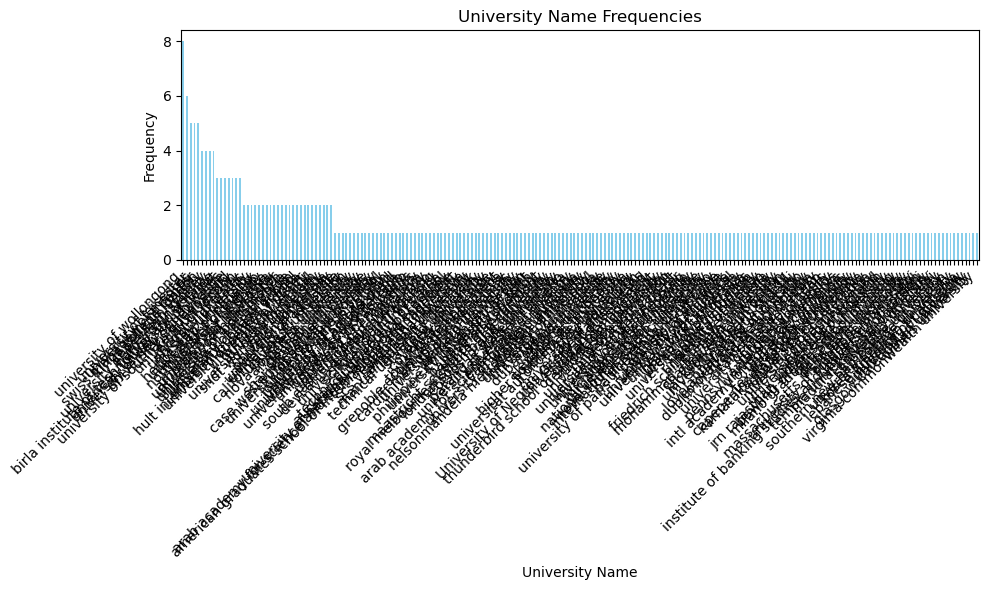

In [46]:
# Count occurrences of each university name
university_counts = sisData['university'].value_counts()
# Plotting the university name frequencies
plt.figure(figsize=(10, 6))
university_counts.plot(kind='bar', color='skyblue')
plt.title('University Name Frequencies')
plt.xlabel('University Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 
plt.tight_layout()  # Adjust layout 
plt.show()

#### 7. 'professional_experience' column

##### ** Minor editing of 'professional_experience' column was done in Excel to facilitate data manipulation

In [47]:
# Upload the edited professional_experience column from the 'professional_exp_edited.xlsx'file
prof_exp = pd.read_excel('professional_exp_edited.xlsx')
sisData['professional_experience'] = prof_exp
sisData['professional_experience'] = sisData['professional_experience'].replace(0, '')
sisData['professional_experience'] = sisData['professional_experience'].map(str)

In [48]:
# Split 'professional_experience' column into 'industry_exp', 'teaching_exp', and 'to_drop' based on '+' delimiter
sisData[['industry_exp', 'teaching_exp', 'to_drop']]= sisData['professional_experience'].str.split('+', expand = True)
# Drop 'to_drop' column as it was created during splitting and isn't needed
sisData = sisData.drop(columns = ['to_drop'])

In [49]:
# Function to extract the first occurrence of a number from a text string
def extract_number(text):
    if isinstance(text, str):
        # Use re.search to find the first occurrence of a number in the text
        match = re.search(r'\b\d+\b', text)
        if match:
            return match.group()  # Return the matched number as a string
        else:
            return ''  # Return empty string if no number is found
    else:
        return ''  # Return empty string if input is not a string

# Apply the function to the 'industry_exp' and 'teaching_exp'
sisData['nyears_industry_exp'] = sisData['industry_exp'].apply(extract_number)
sisData['nyears_teaching_exp'] = sisData['teaching_exp'].apply(extract_number)

In [50]:
# Function to detect whether a person holds a certificate and research or curriculum development experience
def extract_terms(text, existing_values):
    certificate = existing_values['certificate']
    research = existing_values['research']
    curriculum_dev = existing_values['curriculum_dev']
    
    pat_certificate = r'\bcertif\w*'
    pat_research = r'\bresearch\W*'
    pat_curriculum_dev = r'\bcurricul\w*'
    
    if isinstance(text, str):
        if certificate == 0 and re.search(pat_certificate, text):
            certificate = 1
        if research == 0 and re.search(pat_research, text):
            research = 1
        if curriculum_dev == 0 and re.search(pat_curriculum_dev, text):
            curriculum_dev = 1
            
    return pd.Series([certificate, research, curriculum_dev])

# Initialize the 'certificate', 'research', and 'curriculum_dev' columns if they don't exist
if 'certificate' not in sisData.columns:
    sisData['certificate'] = 0
if 'research' not in sisData.columns:
    sisData['research'] = 0
if 'curriculum_dev' not in sisData.columns:
    sisData['curriculum_dev'] = 0

# Apply the function to the 'industry_exp' column
sisData[['certificate', 'research', 'curriculum_dev']] = sisData.apply(
    lambda row: extract_terms(row['industry_exp'], row[['certificate', 'research', 'curriculum_dev']]),
    axis=1)
# Apply the function to the 'teaching_exp' column
sisData[['certificate', 'research', 'curriculum_dev']] = sisData.apply(
    lambda row: extract_terms(row['teaching_exp'], row[['certificate', 'research', 'curriculum_dev']]),
    axis=1)

In [51]:
# Drop no longer needed columns
sisData = sisData.drop(columns=['professional_experience', 'industry_exp', 'teaching_exp'])

#### 8. 'class' column

In [52]:
# Create new column to represent the class/label
sisData[['nyears_industry_exp', 'nyears_teaching_exp']] = sisData[['nyears_industry_exp', 'nyears_teaching_exp']].replace(np.nan, '')

for i in sisData.index:
    if sisData.loc[i, 'nyears_industry_exp'] != '' and sisData.loc[i, 'nyears_teaching_exp'] != '':
        sisData.loc[i, 'class'] = 'industry and teaching experience'
    elif sisData.loc[i, 'nyears_industry_exp'] == '' and sisData.loc[i, 'nyears_teaching_exp'] != '':
        sisData.loc[i, 'class'] = 'teaching experience'
    elif sisData.loc[i, 'nyears_industry_exp'] != '' and sisData.loc[i, 'nyears_teaching_exp'] == '':
        sisData.loc[i, 'class'] = 'industry experience'
    else:
        sisData.loc[i, 'class'] = ''
        
# Clean up the 'class' column by replacing double spaces with single spaces
# and removing any leading or trailing spaces from the text   
sisData['class'] = sisData['class'].str.replace('  ', ' ').str.strip()       

In [53]:
# Replace empty strings with NaN
sisData['nyears_industry_exp'].replace('', np.nan, inplace=True)
sisData['nyears_teaching_exp'].replace('', np.nan, inplace=True)

# # Convert to flat
sisData['nyears_industry_exp'] = sisData['nyears_industry_exp'].astype(float)
sisData['nyears_teaching_exp'] = sisData['nyears_teaching_exp'].astype(float)

# Calculate the sum of 'nyears_industry_exp' and 'nyears_teaching_exp' columns and save it in a new column
sisData['nyears_exp'] = sisData['nyears_industry_exp'] + sisData['nyears_teaching_exp']

/var/folders/xt/fn20mwsn4_13dvr_vrcjcw8h0000gn/T/ipykernel_5067/3803392272.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sisData['nyears_industry_exp'].replace('', np.nan, inplace=True)
/var/folders/xt/fn20mwsn4_13dvr_vrcjcw8h0000gn/T/ipykernel_5067/3803392272.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [54]:
# Drop columns that should not be ingested to the ml 
sisData = sisData.drop(columns=['join_date','nyears_industry_exp', 'nyears_teaching_exp', 'criteria'])

## Re-oder Columns

In [55]:
# Define the desired column order
columns_order = ['location', 'highest_educational_level', 'all_qualifications', 
                   'major', 'university', 'country', 'nyears_exp', 'certificate', 
                   'research', 'curriculum_dev', 'class']

# Rename the 'qualifications' column to 'all_qualifications'
sisData.rename(columns={'qualifications': 'all_qualifications'}, inplace=True)

# Reorder the columns
sisData = sisData.reindex(columns=columns_order)

## Drop rows with missing values

In [56]:
# Replace empty string with NaN
sisData = sisData.replace('', np.nan)

In [57]:
# Drop rows where value is missing in the 'class' columns_order
sisData = sisData.dropna(subset='class')

##### ** The following blocks of code was used to see the count of missing values in each column and extract the rows with missing values

In [58]:
sisData['highest_educational_level'].isnull().value_counts()

highest_educational_level
False    204
True       3
Name: count, dtype: int64

In [59]:
sisData['major'].isnull().value_counts()

major
False    206
True       1
Name: count, dtype: int64

In [60]:
sisData[sisData['major'].isnull()]

,location,highest_educational_level,all_qualifications,major,university,country,nyears_exp,certificate,research,curriculum_dev,class
124,cardiff,mba and msc,"bachelor, masters",NaN,university of pennsylvania,USA,23.0,0,0,0,industry and teaching experience


In [61]:
sisData['all_qualifications'].isnull().value_counts()

all_qualifications
False    207
Name: count, dtype: int64

In [62]:
sisData['university'].isnull().value_counts()

university
False    204
True       3
Name: count, dtype: int64

In [63]:
sisData[sisData['university'].isnull()]

,location,highest_educational_level,all_qualifications,major,university,country,nyears_exp,certificate,research,curriculum_dev,class
19,liverpool,NaN,"diploma, masters",business administration and management,NaN,NaN,20.0,0,0,0,industry and teaching experience
245,leicester,NaN,"bachelor, masters",accounting and finance,NaN,NaN,NaN,0,0,0,industry experience
259,cambridge,NaN,"bachelor, masters, phd",computing business,NaN,NaN,NaN,1,0,0,industry experience


In [64]:
# Check if there any columns with missing values
pd.isnull(sisData).sum()

location                     13
highest_educational_level     3
all_qualifications            0
major                         1
university                    3
country                       5
nyears_exp                   66
certificate                   0
research                      0
curriculum_dev                0
class                         0
dtype: int64

In [65]:
# Drop rows where value is missing in the 'class' columns_order
sisData = sisData.dropna(subset=['location', 'university','country', 'major'])

##### ** Impute missing values in the 'nyears_exp' column with the mean value of the column

In [66]:
# Calculate the mean of the column
mean_value = sisData['nyears_exp'].mean()

mean_value = round(sisData['nyears_exp'].mean(), 1)

# Replace missing values with the mean
sisData['nyears_exp'].fillna(mean_value, inplace=True)

/var/folders/xt/fn20mwsn4_13dvr_vrcjcw8h0000gn/T/ipykernel_5067/365102398.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sisData['nyears_exp'].fillna(mean_value, inplace=True)


## Final brush-up

In [67]:
# Remove leading and trailing whitespaces
columns_to_strip = ['location', 'highest_educational_level', 'all_qualifications', 'major',
       'university', 'country']
sisData[columns_to_strip] = sisData[columns_to_strip].map(lambda x: x.strip())
# Remove excessive blank space between words
sisData = sisData.replace(to_replace = '  ', value=' ', regex=True)
sisData = sisData.replace(to_replace = '\n', value=' ', regex=True)
# Standarize capitalization to lowercase
sisData[columns_to_strip] = sisData[columns_to_strip].apply (lambda x: x.str.lower())
# Remove special characters and extra spaces
sisData[columns_to_strip] = sisData[columns_to_strip].replace(r'[^\w\s]', '', regex=True)

In [68]:
# Rename the DataFrame to 'sisData_clean'
sisData_clean = sisData.copy()
# Save the cleaned DataFrame to a CSV file
file_path = 'sisData_clean.csv'
sisData_clean.to_csv(file_path, index=False)

## Data Preprocessing - Encoding Data

In [69]:
# Create levels for ordinal encoding
first_level = ['dba', 'phd']
second_level = ['mba and ma','mba and mcom','mba and msc']
third_level = ['emba','mba']
fourth_level = ['masters','ma','msc','mcom','llm','mphil']
fifth_level = ['bachelor','bas']

for i in sisData.index:
    row = sisData.loc[i, 'highest_educational_level']
    if row in first_level:
        sisData.loc[i, 'highest_educational_level'] = 'first'
    elif row in second_level:
        sisData.loc[i, 'highest_educational_level'] = 'second'
    elif row in third_level:
        sisData.loc[i, 'highest_educational_level'] = 'third'
    elif row in fourth_level:
        sisData.loc[i, 'highest_educational_level'] = 'fourth'
    else:
        sisData.loc[i, 'highest_educational_level'] = 'fifth'

In [70]:
# Define categorical columns for one-hot encoding
nominal_cols = ['location', 'all_qualifications', 'major', 'university', 'country', 'class']

# Initialize transformers
ode = OrdinalEncoder()
le = LabelEncoder()

# Fit LabelEncoder on the nominal columns
sisData_encoded_nominal = sisData[nominal_cols].apply(le.fit_transform)

# Define column transformer
ct = make_column_transformer(
    (ode, ['highest_educational_level']),
    remainder='passthrough'
)

# Fit and transform the data using the column transformer
sisData_encoded = ct.fit_transform(sisData)

# Combine the transformed nominal columns with the rest of the data
sisData_encoded = pd.concat([sisData_encoded_nominal, pd.DataFrame(sisData_encoded)], axis=1)

In [71]:
sisData_encoded = sisData_encoded.drop(columns = [1, 2, 3, 4, 5, 10])

In [72]:
sisData_encoded = sisData_encoded.dropna(axis=0, how='any')

In [73]:
# Define the desired column order
columns_order = ['location', 0, 'all_qualifications', 
                   'major', 'university', 'country', 6, 7, 8, 9, 'class']

# Reorder the columns
sisData_encoded = sisData_encoded.reindex(columns=columns_order)

# Rename the 'qualifications' column to 'all_qualifications'
sisData_encoded.rename(columns={0: 'highest_educational_level', 6:'nyears_exp', 7:'certificate', 8:'research',9: 'curriculum_dev'}, inplace=True)

In [74]:
# Save the encoded data to a CSV file
sisData_encoded.to_csv('sisData_encoded.csv', index=False)